# AutoML

### Intro

Here we are going to present you an example of bayesian optimization for choosing hyperparameters. 

Consider the following setting. We believe that $f(x)$ is a gaussian field with expectation $\mu(x) = 0$ and covariance function $K(x_1, x_2; \theta)$ which has its own set of parameters $\theta$. However, in fact we only observe noist signal $y_i = f(x_i) + \varepsilon_i$. After observing $y_i$ we can write down posterior distribution at the point $x_*$ as:

\begin{eqnarray}
    \mu_* &=& k_*^{T} (K + \sigma^2I)^{-1} y \\
    \sigma^2_* &=& K(x_*, x_*) - k_*^{T} (K + \sigma^2I)^{-1} k_*,
\end{eqnarray}
where K is the covariance matrix of $f(x)$, $\sigma^2$ is a variance of the noise, $k^*$ is the vector of covariance of the point $x_*$ with the ones that were already observed.

We can use it for choosing the next set of hyperparameters to validate our model. Here is the algorithm:

1) Pick up some random sets of hyperparameters $z_1, \ldots, z_k$

2) Evaluate posterior distribution

3) Pick up a new point using some criteria and repeat steps 2-3

We can also recalculate parameters of covariance function using MLE.

In this project we are going to compare simple GridSearch with bayesian optimization for choosing hyperparameters of a KernelSVM model.

### 0. Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from itertools import product

from sklearn.datasets import make_classification
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

from tqdm.notebook import tqdm

### 1. Creating custom dataset and perform bruteforce search

In [2]:
X, y = make_classification(n_samples=1000, n_features=20, 
                           n_informative=15, n_redundant=5,
                           flip_y=0.05, random_state=10)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

In [3]:
def estimate_kernel_svm(C, gamma, X_train, y_train, X_test, y_test, random_state=10):
    svc = SVC(C=C, gamma=gamma, random_state=random_state)
    svc.fit(X_train, y_train)
    y_test_pred = svc.decision_function(X_test)
    return roc_auc_score(y_test, y_test_pred)

In [4]:
C_values_number = 71
gamma_values_number = 71

C_range = np.logspace(-4, 3, C_values_number)
gamma_range = np.logspace(-4, 3, gamma_values_number)
scores = np.zeros((C_values_number, gamma_values_number))

best_C = -1
best_gamma = -1
best_score = -1

for C_index in tqdm(range(C_values_number)):
    for gamma_index in range(gamma_values_number):
        C = C_range[C_index]
        gamma = gamma_range[gamma_index]
        score = estimate_kernel_svm(C, gamma, X_train, y_train, X_test, y_test)
        scores[gamma_index, C_index] = score
        if score > best_score:
            best_score = score
            best_C = C
            best_gamma = gamma
print('C={}, gamma={}, ROC-AUC: {}'.format(best_C, best_gamma, best_score))


C=3.9810717055349776, gamma=0.003981071705534973, ROC-AUC: 0.9533410138248848


### 2. Bayesian optimization

In [5]:
np.random.seed(100)

C_values_bayes = 701
gamma_values_bayes = 701

grid = np.array(list(product(np.logspace(-4, 3, C_values_bayes), np.logspace(-4, 3, gamma_values_bayes))))

hyperparams = list(grid[np.random.choice(grid.shape[0], size=5, replace=False)])
scores_bayes = []

for C, gamma in hyperparams:
    score = estimate_kernel_svm(C, gamma, X_train, y_train, X_test, y_test)
    
    C_index = np.argwhere(C_range == C)
    gamma_index = np.argwhere(gamma_range == gamma)
    
    scores_bayes.append(score)


best_combination = hyperparams[np.argmax(scores_bayes)]

best_score = np.max(scores_bayes)

max_iters = 120
stop_iters = 20
senseless_iters = 0

kernel = RBF() + WhiteKernel()


for iteration in tqdm(range(max_iters)):
    regressor = GaussianProcessRegressor(kernel, random_state=12)
    regressor.fit(np.log(np.array(hyperparams)), scores_bayes)
    pred, stds = regressor.predict(grid, return_std=True)
    
    C, gamma = grid[np.argmax(stds)]
    hyperparams.append(np.array([C, gamma]))
    score = estimate_kernel_svm(C, gamma, X_train, y_train, X_test, y_test)
    
    scores_bayes.append(score)
                   
    if score > best_score:
        print(score)
        best_score = score
        best_combination = hyperparams[-1]
        
        senseless_iters = 0
        
    else:
        senseless_iters += 1
    
    if senseless_iters == max_iters:
        break

print('C={}, gamma={}, ROC-AUC: {}'.format(best_combination[0], best_combination[1], best_score))

C=218.77616239495518, gamma=0.00016218100973589298, ROC-AUC: 0.9351638504864312


### 3. Heatmap and conclusion

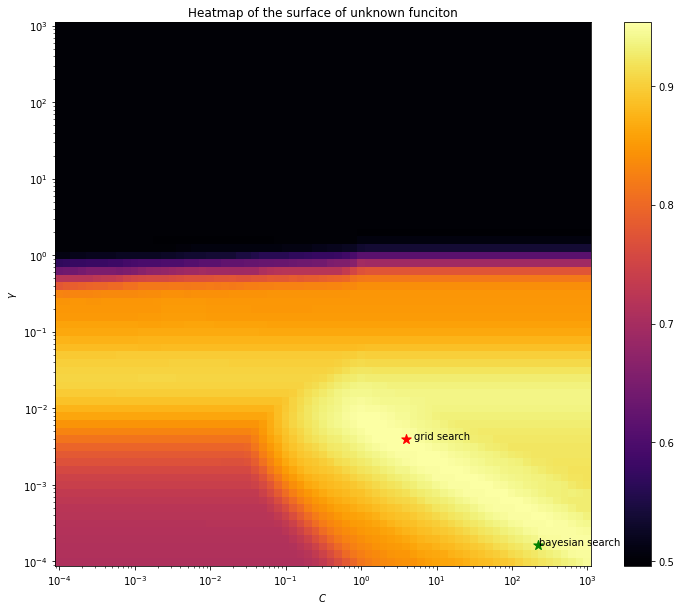

In [11]:
XX, YY = np.meshgrid(C_range, gamma_range)
plt.figure(figsize=(12, 10))
plt.title("Heatmap of the surface of unknown funciton")

plt.pcolormesh(XX, YY, scores, shading='auto', cmap='inferno')
plt.colorbar()

plt.scatter([best_C], [best_gamma], marker='*', color='r', s=100)
plt.text(best_C+1, best_gamma, "grid search")

plt.scatter([best_combination[0]], [best_combination[1]], marker='*', color='g', s=100)
plt.text(best_combination[0]+10, best_combination[1], "bayesian search")
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$C$')
plt.ylabel('$\gamma$');

What we have obtained:

1) Bayesian search can get very close to the optimal value from basic GridSearch

2) Bayesian search is faster and we can operate on a significantly more dense grid of values

3) GridSearch is much easier to parallelize